In [7]:
from numpy import loadtxt
import numpy as np
import numpy as np
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import joblib
import time
from sklearn.model_selection import train_test_split

In [8]:
#installing drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
#positions = np.load('/content/drive/MyDrive/My_stratego_project/files/X_encoded_positions.txt') #load datasets
winners = pd.read_csv("/content/drive/MyDrive/My_stratego_project/files/Y_winners_encoded.csv", header = None)
positions = joblib.load('/content/drive/MyDrive/My_stratego_project/files/X_encoded_positions.txt')
positions = np.array(positions).reshape(99132, 40, 12) #Reshaping the data to a 40 by 12 matrix

In [10]:
"""for -1 to 1 classification, changes winner variable to -1 and 1, comment out to use 0/1 classification"""
winners_new = []
i=0
for winner in winners[0]:
  if winner == 0:
    winners_new.append(winner)
  else:
    winners_new.append(winner)
  i+=1

In [11]:
"""Creates 4 edge indeces based on the sizes created after the sagpooling operation, they're all square boards"""

##Possible imporvement to be added is to create edge index based on removed and included nodes after the sagpooling operation
def edge_index(row,column):
  """Creates a edge index based on a number of rows and columns as input"""
  edge_index = []
  for row in range(num_rows):
      for col in range(num_cols):
          node_idx = row * num_cols + col

          if row > 0:  #connect to top neighbor
              top_neighbor_idx = (row - 1) * num_cols + col
              edge_index.append([node_idx, top_neighbor_idx])

          if row < num_rows - 1:  #connect to bottom neighbor
              bottom_neighbor_idx = (row + 1) * num_cols + col
              edge_index.append([node_idx, bottom_neighbor_idx])

          if col > 0:  #connect to left neighbor
              left_neighbor_idx = row * num_cols + (col - 1)
              edge_index.append([node_idx, left_neighbor_idx])

          if col < num_cols - 1:  #connect to right neighbor
              right_neighbor_idx = row * num_cols + (col + 1)
              edge_index.append([node_idx, right_neighbor_idx])

  return torch.tensor(edge_index).t().contiguous()

num_rows = 4
num_cols = 10
edge_index1 = edge_index(num_rows , num_cols)#(4,10)
edge_index1 = np.array(edge_index1)

In [12]:
edge_index1[1]

array([10,  1, 11,  0,  2, 12,  1,  3, 13,  2,  4, 14,  3,  5, 15,  4,  6,
       16,  5,  7, 17,  6,  8, 18,  7,  9, 19,  8,  0, 20, 11,  1, 21, 10,
       12,  2, 22, 11, 13,  3, 23, 12, 14,  4, 24, 13, 15,  5, 25, 14, 16,
        6, 26, 15, 17,  7, 27, 16, 18,  8, 28, 17, 19,  9, 29, 18, 10, 30,
       21, 11, 31, 20, 22, 12, 32, 21, 23, 13, 33, 22, 24, 14, 34, 23, 25,
       15, 35, 24, 26, 16, 36, 25, 27, 17, 37, 26, 28, 18, 38, 27, 29, 19,
       39, 28, 20, 31, 21, 30, 32, 22, 31, 33, 23, 32, 34, 24, 33, 35, 25,
       34, 36, 26, 35, 37, 27, 36, 38, 28, 37, 39, 29, 38])

Strategy 1; Surround flag by bombs

In [14]:
import numpy as np
b_f_ratio_list = []
# Loop through the positions dataset
for position in positions:
    # Get flag and bomb positions
    flag_pos = np.where(position[:, 11] == 1)[0]
    bomb_positions = np.where(position[:, 0] == 1)[0]

    # Get outgoing edges from bombs
    index_list_bomb = [index for index, val in enumerate(edge_index1[0]) if val in bomb_positions]
    outedge_bomb = edge_index1[1, index_list_bomb]

    # Get outgoing edges from flag
    index_list_flag = [index for index, val in enumerate(edge_index1[0]) if val in flag_pos]
    outedge_flag = edge_index1[1, index_list_flag]

    bomb_count_adj_flag = np.count_nonzero(outedge_bomb == flag_pos)
    # Calculate ratio
    if bomb_count_adj_flag != 0:
      ratio =  bomb_count_adj_flag / len(outedge_flag)
    else:
      ratio=0
    #create list for ratio's flag outgoing edges of flag covered by bombs
    b_f_ratio_list.append(ratio)
len(b_f_ratio_list)

99132

In [15]:
b_f_ratio_list[0]

1.0

Strategy 2; 10 and 9 distance to each other

In [16]:
import numpy as np
distance_10_to_9_list = []
# Loop through the positions dataset
for position in positions:
    # Get marshal and general positions
    marshal_pos = np.where(position[:, 10] == 1)[0]
    general_pos = np.where(position[:, 9] == 1)[0]

    # Calculate the row and column indices for each position
    row1 = general_pos//10
    col1 = general_pos-(row1*10)
    row2 = marshal_pos//10
    col2 = marshal_pos-(row2*10)
    # Calculate the absolute difference in row and column positions
    row_diff = abs(row2 - row1)
    col_diff = abs(col2 - col1)

    # Calculate the number of spaces between the two pieces
    num_spaces = int((row_diff + col_diff)[0])
    distance_10_to_9_list.append(num_spaces)
len(distance_10_to_9_list)

99132

In [17]:
row_diff = abs(row2 - row1)
col_diff = abs(col2 - col1)
row_diff+col_diff, distance_10_to_9_list[-1] #check whether its correct

(array([2]), 2)

Strategy 3; Distance of spy to general

In [18]:
import numpy as np
distance_spy_to_9_list = []
# Loop through the positions dataset
for position in positions:
    # Get spy and general positions
    spy_pos = np.where(position[:, 1] == 1)[0]
    general_pos = np.where(position[:, 9] == 1)[0]

    # Calculate the row and column indices for each position
    row1 = general_pos//10
    col1 = general_pos-(row1*10)
    row2 = spy_pos//10
    col2 = spy_pos-(row2*10)
    # Calculate the absolute difference in row and column positions
    row_diff = abs(row2 - row1)
    col_diff = abs(col2 - col1)

    # Calculate the number of spaces between the two pieces
    num_spaces = int((row_diff + col_diff)[0])
    distance_spy_to_9_list.append(num_spaces)
len(distance_spy_to_9_list)

99132

In [19]:
row_diff = abs(row2 - row1)
col_diff = abs(col2 - col1)
row_diff+col_diff, distance_10_to_9_list[-1] #check whether its correct

(array([2]), 2)

Strategy 4; number of bombs on front row

In [20]:
import numpy as np
num_bomb_first_row_list = []
# Loop through the positions dataset
for position in positions:
    bomb_pos = np.where(position[:, 0] == 1)[0]

    num_bombs_first_row = np.count_nonzero(bomb_pos//10==3)



    num_bomb_first_row_list.append(num_bombs_first_row)
len(num_bomb_first_row_list)

99132

In [21]:
num_bomb_first_row_list[0]

0

Strategy 5; Number of miners on the last row

In [22]:
import numpy as np
num_miners_last_row_list = []
# Loop through the positions dataset
for position in positions:
    miner_pos = np.where(position[:, 3] == 1)[0]

    num_miners_last_row = np.count_nonzero(miner_pos//10==0)



    num_miners_last_row_list.append(num_miners_last_row)
len(num_miners_last_row_list)

99132

In [23]:
miner_pos//10

array([2, 2, 3, 3, 3])

Strategy 6; Scouts both in front and back rows

In [24]:
import numpy as np
average_row_scouts_list = []
# Loop through the positions dataset
for position in positions:
    scouts_pos = np.where(position[:, 2] == 1)[0]

    scouts_on_rows = scouts_pos//10
    average_row_scouts = sum(scouts_on_rows)/len(scouts_on_rows)


    average_row_scouts_list.append(average_row_scouts)
len(average_row_scouts_list)

99132

In [25]:
np.mean(average_row_scouts_list)

1.4936297058467498

Strategy 7; Average Rank corridors(excluding bombs and flags)

In [26]:
import numpy as np
corridor_strength_list_dataset = []
corridor_list = [[0,1,2],[3,4,5,6],[7,8,9]]#represents the corridors thus blocks of units close to each other potentiall relevant to the game
# Loop through the positions dataset
for position in positions:
  corridor_strength_list_match = []
  for corridor in corridor_list:
      mask = np.arange(position.reshape(4,10,12)[:,corridor].shape[2]) >= 1
      mask &= np.arange(position.reshape(4,10,12)[:,corridor].shape[2]) < 10  #creates mask such that flags and bombs are excluded

      # Apply the mask and get the column numbers for each row
      column_numbers = np.where(position.reshape(4,10,12)[:,corridor] * mask, np.arange(position.reshape(4,10,12)[:,corridor].shape[2]) + 1, 0)

      corridor_strength = np.sum(column_numbers)/(column_numbers.shape[0]*column_numbers.shape[1])
      corridor_strength_list_match.append(corridor_strength)
  corridor_strength_list_dataset.append(corridor_strength_list_match)
len(corridor_strength_list_dataset)

99132

In [27]:
corridor_strength_list_dataset[0]

[4.416666666666667, 3.875, 4.583333333333333]

Adding the data to the dataset

In [28]:
var_list = []
var_list.append(b_f_ratio_list)
var_list.append(distance_10_to_9_list)
var_list.append(distance_spy_to_9_list)
var_list.append(num_bomb_first_row_list)
var_list.append(num_miners_last_row_list)
var_list.append(average_row_scouts_list)
var_list.append(corridor_strength_list_dataset)

In [29]:
n_samples, n_rows, n_cols = positions.shape

new_cols_total = n_cols + 9
positions_expanded = np.zeros((n_samples, n_rows, new_cols_total))

# Copy original positions data
positions_expanded[:, :, :n_cols] = positions


In [30]:
n_samples, n_rows, n_cols = positions.shape

new_cols_total = n_cols + 9
positions_expanded = np.zeros((n_samples, n_rows, new_cols_total))

# Copy original positions data
positions_expanded[:, :, :n_cols] = positions
cnt = 0
for var in var_list:
  cnt +=1
  for index, i in enumerate(positions_expanded):
    #print(var_list[cnt][index])
    if cnt >= 7:
      #for val in var
      positions_expanded[index,:,n_cols+cnt-1] = var_list[6][index][0]
      positions_expanded[index,:,n_cols+cnt] = var_list[6][index][1]
      positions_expanded[index,:,n_cols+cnt+1] = var_list[6][index][2]
    else:
      positions_expanded[index,:,n_cols+cnt] = var_list[cnt-1][index]

only_var_pos =  positions_expanded[:,:,12:]

In [31]:
var_list[0][0]

1.0

In [32]:
positions_expanded[:,:,12:][0][0]

array([0.        , 1.        , 3.        , 1.        , 0.        ,
       4.        , 4.41666667, 3.875     , 4.58333333])

In [33]:
only_var_pos[0][0]

array([0.        , 1.        , 3.        , 1.        , 0.        ,
       4.        , 4.41666667, 3.875     , 4.58333333])

In [34]:
positions_expanded[:,:,-1].shape

(99132, 40)

Logistic Regression and statistical analysis

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [36]:
data_selected = np.mean(only_var_pos, axis=1)  # You can use np.median, np.max, np.min, etc. as needed

In [37]:

X_train, X_test, y_train, y_test = train_test_split(data_selected, winners_new, test_size=0.2, random_state=42)

# Initialize the logistic regression model
model = LogisticRegression(max_iter=1000)  # Increased max_iter to ensure convergence

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.5236


In [38]:
data_selected.shape

(99132, 9)

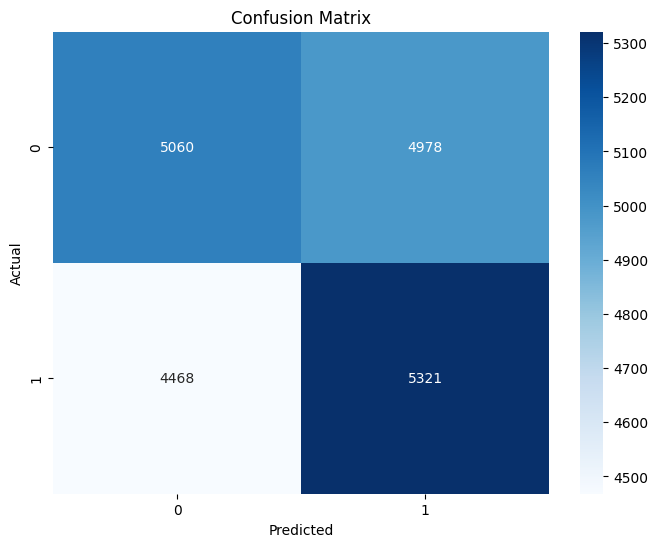

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc



# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_selected, winners_new, test_size=0.2, random_state=42)

# Initialize the logistic regression model
model = LogisticRegression(max_iter=1000)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


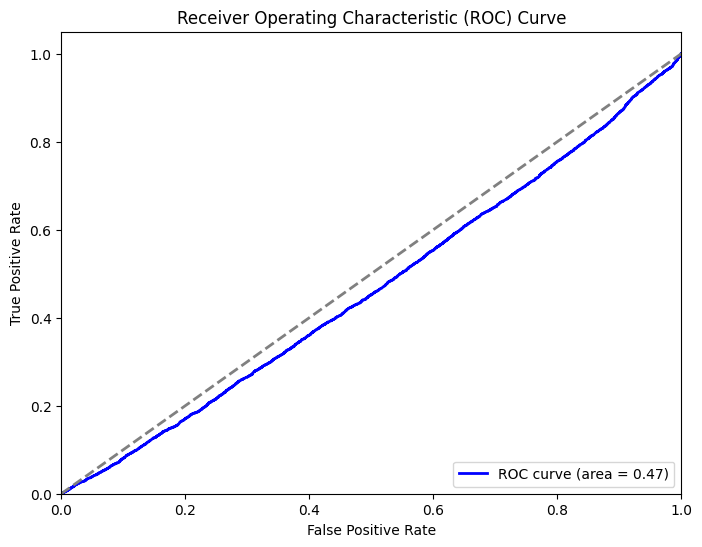

In [40]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

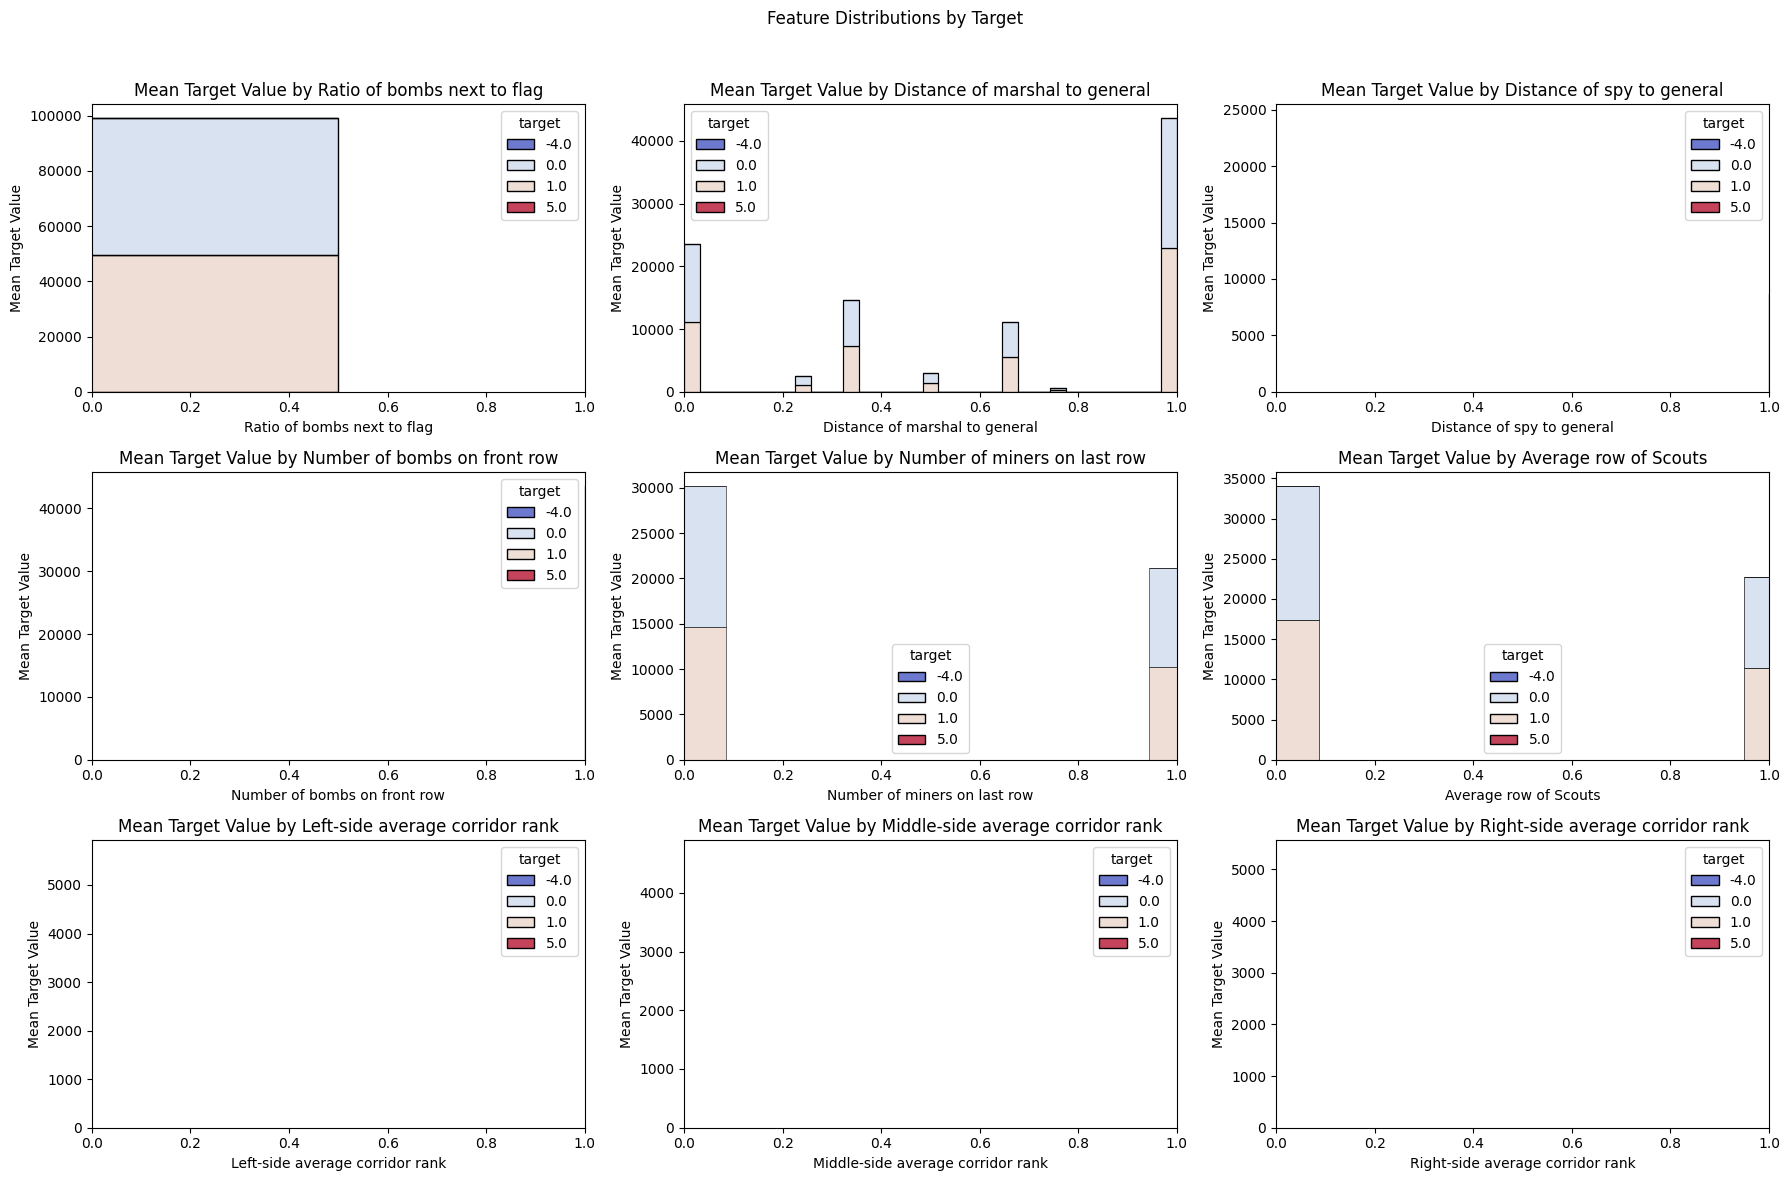

In [44]:
import seaborn as sns
# Convert data to DataFrame for easier plotting
columns = [f'feature_{i}' for i in range(data_selected.shape[1])]
df = pd.DataFrame(data_selected, columns=columns)
df.rename(columns={
    'feature_0': 'Ratio of bombs next to flag',
    'feature_1': 'Distance of marshal to general',
    'feature_2': 'Distance of spy to general',
    'feature_3': 'Number of bombs on front row',
    'feature_4': 'Number of miners on last row',
    'feature_5': 'Average row of Scouts',
    'feature_6': 'Left-side average corridor rank',
    'feature_7': 'Middle-side average corridor rank',
    'feature_8': 'Right-side average corridor rank'
}, inplace=True)
df['target'] = winners_new

# Plotting
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
fig.suptitle('Feature Distributions by Target')

for i, ax in enumerate(axes.flatten()):
    if i < 9:  # We only have 9 features to plot
        feature_col = df.columns[i]

        # Calculate the mean target value for each value of the feature
        means_by_feature = df.groupby(feature_col)['target'].mean()

        # Plot the mean target value for each value of the feature
        #means_by_feature.plot(ax=ax, marker='o', linestyle='-')
        sns.histplot(data=df, x=feature_col, hue='target', multiple='stack', ax=ax, palette='coolwarm')
        ax.set_title(f'Mean Target Value by {feature_col}')
        ax.set_xlim(0,1)
        ax.set_xlabel(feature_col)
        ax.set_ylabel('Mean Target Value')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()